<div align="center">
  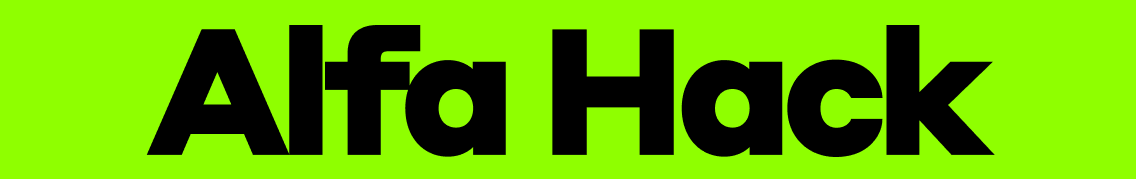
</div>

## Этап 1. Установка библиотек и импорт данных

In [24]:
# Cкачиваем необходимые библиотеки для работы
!pip install pandas numpy scikit-learn
!pip install optuna

In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import glob
import os
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import optuna

Подключаемся в Google Drive, чтобы работать с файлами из Google Colaboratory

In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Указываем путь к корневым папкам с данными test и train

__Обратите внимание:__ если вы создали папку с названием отличным от _"Хакатон Альфа-банка. Кейс 1"_, то необходимо поменять путь к директории и ссылки ниже

In [27]:
# Путь к папке с тренировочными данными
path_train = '/content/drive/MyDrive/Кейс-1. Кредитный скоринг юридических лиц/train'

# Путь к папке с тестовыми данными
path_test = '/content/drive/MyDrive/Кейс-1. Кредитный скоринг юридических лиц/test'

Получим список файлов в каждой из папок с данными

In [28]:
print(*[f'Список файлов в репозитории {x.split("/")[-1]}: {sorted(os.listdir(x), key=lambda x: len(x))}' for x in [path_train, path_test]], sep='\n')

Список файлов в репозитории train: ['train_9.csv', 'train_7.csv', 'train_4.csv', 'train_5.csv', 'train_8.csv', 'train_2.csv', 'train_3.csv', 'train_6.csv', 'train_1.csv', 'train_10.csv']
Список файлов в репозитории test: ['test_9.csv', 'test_2.csv', 'test_8.csv', 'test_5.csv', 'test_6.csv', 'test_3.csv', 'test_4.csv', 'test_7.csv', 'test_1.csv', 'test_10.csv']


Объединим тренировочные и тестовые данные в единые датасеты train и test

In [29]:
# Получим список путей к файлам в папке train
filenames_train = glob.glob(path_train + "/*.csv")

# Создадим список для записи считанных файлов train
data_files_train = []

# Считаем все файлы train и добавим их в список
for filename in filenames_train:
    data_files_train.append(pd.read_csv(filename))

# Объединим тренировочные данные в единый датасет
data_train = pd.concat(data_files_train, ignore_index=True)

# Выведем информацию о размерности полученных тренировочных данных
display('Размерность полных тренировочных данных составляет: {} строка и {} столбец'.format(*data_train.shape))

# Выведем первые 5 строк тренировочных данных
display(data_train.head())

# Удостоверимся, что перед нами данные только из выборки train
data_train['smpl'].value_counts(dropna=False)

'Размерность полных тренировочных данных составляет: 38731 строка и 421 столбец'

,target,smpl,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
0,0,train,30984,-1.685150,0.036641,0.0,0.184206,0.556771,0.621198,0.412668,...,-0.965186,-2.298634,0.0,1.048785,-1.968783,-0.103378,0.956470,-0.057758,1.247883,-0.264342
1,0,train,30985,0.284329,-0.440422,1.0,-0.967560,0.294005,-0.510407,-1.035914,...,1.004524,-0.986434,0.0,0.549722,0.073823,-1.282835,-0.389573,-0.026846,0.446014,0.025077
2,0,train,30986,0.266531,-1.101074,0.0,0.421567,-0.231063,1.339101,0.179125,...,0.993679,0.223101,0.0,0.317462,1.306815,0.778160,1.388686,-1.781022,0.806390,0.089581
3,0,train,30987,1.998720,-0.142911,0.0,-0.116260,1.007793,0.864204,-1.550267,...,0.908101,-0.721558,0.0,0.813355,1.106078,-1.133465,-0.466997,-0.891079,-0.370554,1.180865
4,1,train,30988,-0.880000,-1.295599,1.0,-0.618625,-0.224974,-1.855562,-0.858830,...,0.004776,-0.173025,0.0,-0.028972,-0.306650,-0.915380,-0.788745,-0.262882,0.633912,0.511296


,count
smpl,
train,38731


In [30]:
# Получим список путей к файлам в папке test
filenames_test = glob.glob(path_test + "/*.csv")

# Создадим список для записи считанных файлов test
data_files_test = []

# Считаем все файлы test и добавим их в список
for filename in filenames_test:
    data_files_test.append(pd.read_csv(filename))

# Объединим тестовые данные в единый датасет
data_test = pd.concat(data_files_test, ignore_index=True)

# Выведем информацию о размерности полученных тестовых данных
display('Размерность полных тренировочных данных составляет: {} строк и {} столбцов'.format(*data_test.shape))

# Выведем первые 5 строк тренировочных данных
display(data_test.head())

# Удостоверимся, что перед нами данные только из выборки test
data_test['smpl'].value_counts(dropna=False)

'Размерность полных тренировочных данных составляет: 19826 строк и 420 столбцов'

,smpl,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
0,test,54587,0.746069,1.491042,1.0,-2.368890,-1.588643,-1.525789,-1.455572,-1.591832,...,0.213686,0.225635,0.0,0.074422,-1.406543,-0.448425,-0.907559,-0.459252,1.180903,-1.038134
1,test,54588,0.921215,-0.557271,1.0,-0.844925,0.037427,-0.666643,-0.704630,-1.200048,...,1.021515,-0.634403,0.0,0.658217,-0.197828,-0.714108,-0.457458,0.148108,-2.099486,-0.562876
2,test,54589,-0.844275,1.361876,0.0,0.581095,-0.523420,-0.054810,0.731334,1.156945,...,-1.058477,1.381829,0.0,0.315537,-1.107333,1.304356,0.787249,-0.803347,-0.891007,0.925607
3,test,54590,-0.006888,0.492680,0.0,-0.038298,1.822206,0.585984,1.312741,1.079441,...,1.689817,1.842281,0.0,-1.116152,-0.913065,1.163096,0.159401,1.007840,0.779470,-2.326777
4,test,54591,1.000997,-0.112418,0.0,-0.209493,-0.347011,-0.315501,2.277442,-1.242267,...,0.170574,0.113771,0.0,-0.651531,1.758280,-1.665348,-0.444426,0.832037,0.738305,-2.654819


,count
smpl,
test,19826


In [31]:
data_train

,target,smpl,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
0,0,train,30984,-1.685150,0.036641,0.0,0.184206,0.556771,0.621198,0.412668,...,-0.965186,-2.298634,0.0,1.048785,-1.968783,-0.103378,0.956470,-0.057758,1.247883,-0.264342
1,0,train,30985,0.284329,-0.440422,1.0,-0.967560,0.294005,-0.510407,-1.035914,...,1.004524,-0.986434,0.0,0.549722,0.073823,-1.282835,-0.389573,-0.026846,0.446014,0.025077
2,0,train,30986,0.266531,-1.101074,0.0,0.421567,-0.231063,1.339101,0.179125,...,0.993679,0.223101,0.0,0.317462,1.306815,0.778160,1.388686,-1.781022,0.806390,0.089581
3,0,train,30987,1.998720,-0.142911,0.0,-0.116260,1.007793,0.864204,-1.550267,...,0.908101,-0.721558,0.0,0.813355,1.106078,-1.133465,-0.466997,-0.891079,-0.370554,1.180865
4,1,train,30988,-0.880000,-1.295599,1.0,-0.618625,-0.224974,-1.855562,-0.858830,...,0.004776,-0.173025,0.0,-0.028972,-0.306650,-0.915380,-0.788745,-0.262882,0.633912,0.511296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38726,0,train,3868,0.810779,-0.100837,0.0,0.113818,-0.709053,-1.225323,0.812546,...,1.610277,0.016244,0.0,0.703146,-0.346095,-1.702312,-0.725359,0.621535,0.054476,0.784127
38727,0,train,3869,2.238330,0.994643,0.0,0.940327,-0.465618,-0.769000,0.099768,...,-0.750319,0.491252,0.0,0.259846,0.777859,0.722524,-0.154725,0.825575,1.385096,-0.739719
38728,0,train,3870,-0.644076,-0.072378,0.0,1.212203,0.301982,-1.457271,0.598599,...,-0.758266,0.671982,0.0,0.420039,-1.248479,1.571119,0.001783,0.991628,-0.578334,1.258159
38729,0,train,3871,-0.334598,-0.692079,0.0,-0.258802,-0.343323,-0.146532,0.772228,...,-2.914545,0.598839,0.0,1.687699,0.627274,-0.826840,-0.055077,0.891023,-0.474208,2.172240


In [32]:
data_test

,smpl,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
0,test,54587,0.746069,1.491042,1.0,-2.368890,-1.588643,-1.525789,-1.455572,-1.591832,...,0.213686,0.225635,0.0,0.074422,-1.406543,-0.448425,-0.907559,-0.459252,1.180903,-1.038134
1,test,54588,0.921215,-0.557271,1.0,-0.844925,0.037427,-0.666643,-0.704630,-1.200048,...,1.021515,-0.634403,0.0,0.658217,-0.197828,-0.714108,-0.457458,0.148108,-2.099486,-0.562876
2,test,54589,-0.844275,1.361876,0.0,0.581095,-0.523420,-0.054810,0.731334,1.156945,...,-1.058477,1.381829,0.0,0.315537,-1.107333,1.304356,0.787249,-0.803347,-0.891007,0.925607
3,test,54590,-0.006888,0.492680,0.0,-0.038298,1.822206,0.585984,1.312741,1.079441,...,1.689817,1.842281,0.0,-1.116152,-0.913065,1.163096,0.159401,1.007840,0.779470,-2.326777
4,test,54591,1.000997,-0.112418,0.0,-0.209493,-0.347011,-0.315501,2.277442,-1.242267,...,0.170574,0.113771,0.0,-0.651531,1.758280,-1.665348,-0.444426,0.832037,0.738305,-2.654819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19821,test,58552,-0.458810,0.760797,0.0,0.905835,-2.284900,0.836652,1.816489,-0.003760,...,-1.123098,1.680038,0.0,-0.924689,1.491165,0.824548,1.285684,1.112194,-0.456114,0.552107
19822,test,58553,1.034478,-1.861589,0.0,0.099505,1.574147,3.051596,0.847902,0.878402,...,1.181290,0.985806,0.0,-2.334676,-0.330389,-0.630688,-0.723622,-0.221162,1.296415,-1.278838
19823,test,58554,0.673612,0.728412,1.0,-0.375495,-0.718471,-0.680123,-1.877311,-0.531344,...,-0.983693,-1.357330,0.0,-0.151172,-0.514823,-0.331970,-1.104892,0.679688,-1.046627,-1.753764
19824,test,58555,-0.867507,1.794203,0.0,0.370215,0.302920,1.841912,-0.770354,0.088733,...,-0.631363,-0.503742,0.0,1.278114,-0.812663,0.185593,0.713361,0.712688,2.300315,-1.754661


## Этап 2. Работа с моделью

In [33]:
# # Выделим признаки для обучения и искомый признак в датасете train
# # для обучения модели
# X = data_train.drop(['target', 'smpl'], axis=1)
# y = data_train['target']

# # Разобьем тренировочные данные на валидационный и тренировочный датасет в соотношении 7 к 3
# # Cтратифицируем выборки по искомому признаку, зафиксируем random_state для воспроизводимости
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.3)

# # Обучим модель на тренировочной части тренировочных данных
# gbdt_clf = HistGradientBoostingClassifier(min_samples_leaf=1,
#                                           max_depth=20,
#                                           max_iter=125,
#                                           random_state=42).fit(X_train, y_train)

# # Получим предсказание с вероятностями для валидационной части тренировочного датасета
# y_pred = gbdt_clf.predict_proba(X_test)

# # Переведем предсказание в формат Series
# y_pred = pd.Series(y_pred[:, 1])

# # Высчитаем метрику roc-auc по валидационным данным
# print(f'Метрика roc-auc на валидационных данных имеет значение: {roc_auc_score(y_test, y_pred)}')

## Этап 3. Предсказание для тестовых данных



Получим предсказание на тестовых данных

In [34]:
# # Обучим модель на полных тренировочных данных
# gbdt_clf = HistGradientBoostingClassifier(min_samples_leaf=1,
#                                           max_depth=20,
#                                           max_iter=125,
#                                           random_state=42).fit(X, y)

# # Для предсказания используем тестовый датасет с исключенным признаком smpl
# y_test_pred = gbdt_clf.predict_proba(data_test.drop(['smpl'], axis=1))

# # Переведем предсказание в формат Series
# y_test_pred = pd.Series(y_test_pred[:, 1])

# # Добавим данные предсказания к датасету
# data_test['target'] = y_test_pred

# # Сохраним итоговые данные об id и предсказаниях в формате csv
# data_test[['id', 'target']].to_csv('baseline_submission_case1.csv', index=False)

# Решение:

# Отбор фичей

In [ ]:
# Разделение на признаки и целевую переменную
X = data_train.drop(columns=['target', 'id', 'smpl'])
y = data_train['target']

# Отбор важных признаков с использованием GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(X, y)

# Селектор фич, у которых importance выше среднего значения
selector = SelectFromModel(model, threshold="mean", prefit=True)
X_selected = selector.transform(X)

print("Количество выбранных признаков:", X_selected.shape[1])

# Применение селектора к тестовому набору данных
X_test = data_test.drop(columns=['id', 'smpl'])
X_test_selected = selector.transform(X_test)

In [ ]:
# Находим выбранные признаки
# Получаем маску выбранных признаков из селектора
selected_features_mask = selector.get_support()

# Извлекаем названия выбранных признаков, используя маску
selected_features = X.columns[selected_features_mask]
selected_features = selected_features.tolist()

print("Выбранные признаки:", selected_features)

Так как у кода сверху есть рандомность, сохраним все фичи при лучшем скоре в массив только важных фич:

In [35]:
im_f = ['feature_2', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_11', 'feature_19', 'feature_22', 'feature_37', 'feature_38', 'feature_40', 'feature_41', 'feature_42', 'feature_45', 'feature_51', 'feature_52', 'feature_59', 'feature_63', 'feature_65', 'feature_66', 'feature_67', 'feature_71', 'feature_72', 'feature_75', 'feature_77', 'feature_79', 'feature_82', 'feature_83', 'feature_86', 'feature_87', 'feature_93', 'feature_94', 'feature_100', 'feature_102', 'feature_109', 'feature_114', 'feature_116', 'feature_117', 'feature_124', 'feature_128', 'feature_131', 'feature_134', 'feature_144', 'feature_145', 'feature_147', 'feature_149', 'feature_150', 'feature_152', 'feature_154', 'feature_155', 'feature_163', 'feature_166', 'feature_167', 'feature_171', 'feature_174', 'feature_177', 'feature_185', 'feature_186', 'feature_195', 'feature_201', 'feature_208', 'feature_213', 'feature_217', 'feature_219', 'feature_223', 'feature_231', 'feature_234', 'feature_235', 'feature_236', 'feature_241', 'feature_250', 'feature_252', 'feature_256', 'feature_257', 'feature_258', 'feature_259', 'feature_261', 'feature_267', 'feature_269', 'feature_271', 'feature_272', 'feature_275', 'feature_276', 'feature_277', 'feature_278', 'feature_283', 'feature_285', 'feature_286', 'feature_288', 'feature_289', 'feature_290', 'feature_292', 'feature_298', 'feature_300', 'feature_304', 'feature_307', 'feature_315', 'feature_316', 'feature_321', 'feature_324', 'feature_331', 'feature_333', 'feature_345', 'feature_350', 'feature_352', 'feature_353', 'feature_354', 'feature_355', 'feature_356', 'feature_357', 'feature_358', 'feature_363', 'feature_365', 'feature_366', 'feature_368', 'feature_370', 'feature_371', 'feature_376', 'feature_384', 'feature_386', 'feature_390', 'feature_391', 'feature_397', 'feature_402', 'feature_403', 'feature_416', 'feature_417']
len(im_f)

127

Кол-во отобранных фичей - 128

Возьмем только важные фичи для обучения и предсказания:

In [36]:
X_selected = data_train[im_f].copy()
X_test_selected = data_test[im_f].copy()
y = data_train['target']

# Определение модели и кросс валидации:

Посмотрим на дефолтный скор + определим сетку для кросс-валидации.

Также добавим стратификацию на кросс-валидацию, так как количество элементов с target == 1 много больше других.

Также для нахождения лучшей модели, описыывающей данные, зафиксируем данные - в кросс-валидации будем использовать random_state = 10.

In [37]:
# Обучаем LightGBM с кросс-валидацией на выбранных признаках
lgb_model = lgb.LGBMClassifier(verbose = -1)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10) # стратификация по таргету
scores = cross_val_score(lgb_model, X_selected, y, cv=skf, scoring='roc_auc')
print("ROC-AUC на LightGBM с кросс-валидацией:", scores.mean())

ROC-AUC на LightGBM с кросс-валидацией: 0.7593598666115142


#**Поиск гиперпараметров**

Для поиска гиперпараметров будем использовать open-source библиотеку для поиска гиперпараметров optuna:

In [ ]:
# Определяем функцию для оптимизации гиперпараметров
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'num_leaves': trial.suggest_int('num_leaves', 150, 200),
        'n_estimators': trial.suggest_int('n_estimators', 400, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 30, 50),
        'subsample': trial.suggest_float('subsample', 0.9, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1.0),
    }
    model = lgb.LGBMClassifier(**param)
    scores = cross_val_score(model, X_selected, y, cv=skf, scoring='roc_auc')
    return scores.mean()

# Запускаем Optuna для оптимизации
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Получаем лучшие параметры
best_params = study.best_params
print("Лучшие параметры:", best_params)

Зафиксируем параметры которые получились при обучении:

In [38]:
best_params = {'learning_rate': 0.01290806719885743, 'max_depth': 3, 'num_leaves': 156, 'n_estimators': 500, 'min_child_samples': 32, 'subsample': 0.9052108095701373, 'colsample_bytree': 0.9153415375057271, 'lambda_l1': 0.5216384377631789, 'lambda_l2': 0.5141215730887658}

Пробуем как у гриши rs=None

In [96]:
# Финальное обучение модели с лучшими параметрами
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_selected, y)

# Предсказания для тестовых данных
y_test_pred = final_model.predict_proba(X_test_selected)[:, 1]

submission = pd.DataFrame({
    'id': data_test['id'],
    'target': y_test_pred
})
# Сохраняем результат в csv файл
submission.to_csv('cheak.csv', index=False)

Сохраним модель lightGBM с помощью joblib и pickle:

In [97]:
# Библиотеки для сохранения модели
import joblib
import pickle

joblib.dump(final_model, r'light_rs_None.joblib')

with open('light_rs_None.pkl', 'wb') as f:
  pickle.dump(final_model, f)

Сравнив результаты с тем, что отправили на сервер

In [108]:
ex = pd.read_csv('/content/light_rs_NONE.csv') # то, что отправили на тест
re_ex = pd.read_csv('/content/cheak.csv') # вопспроизводитмая модель

ex = ex.sort_values('id')
re_ex = re_ex.sort_values('id')

In [110]:
(ex['target'].to_numpy() == re_ex['target'].to_numpy()).sum()

19826

#**Результаты совпадают => модель воспроизводима**